1. References/ intital Code link:
2. https://github.com/vjrahil/Face-Generator/blob/master/dlnd_face_generation.ipynb - code initial
3. https://towardsdatascience.com/fake-face-generator-using-dcgan-model-ae9322ccfd65 - best explanation of code implemented

In [1]:
import os
import glob
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import timeit

In [7]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms

import problem_unittests as tests

### Checks if Data is already extracted: if not, then execute extraction else skip

In [4]:
#already extracted

MYDIR = ("Data/img_align_celeba_png/faces") #32600 images for now #Data/celeb_A_extract
CHECK_FOLDER = os.path.isdir(MYDIR)

if not CHECK_FOLDER:
    shutil.unpack_archive('Data/processed-celeba-small.zip', 'Data/celeb_A_extract')
    print("Extraction completed...")
else:
    print(MYDIR,"folder already exists")

'\nMYDIR = ("Data/img_align_celeba_png/faces") #32600 images for now #Data/celeb_A_extract\nCHECK_FOLDER = os.path.isdir(MYDIR)\n\nif not CHECK_FOLDER:\n    shutil.unpack_archive(\'Data/processed-celeba-small.zip\', \'Data/celeb_A_extract\')\n    print("Extraction completed...")\nelse:\n    print(MYDIR,"folder already exists")'

### Fetching pre-processed data

In [8]:
def get_dataloader(batch_size, image_size, data_dir='Data/celeb_A_extract/processed_celeba_small/celeba'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    #Multiple transforms performed usng compose on images -> then converted to tensor images
    transform = transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor()])
    # TODO: Implement function and return a dataloader
    dataset = datasets.ImageFolder(data_dir,transform = transform)

    #Dataloader provides easy access to each element, it can be iteratable
    dataloader = torch.utils.data.DataLoader(dataset = dataset,batch_size = batch_size,shuffle = True)
    return dataloader

### Gets dataloader based on batch size and img size

In [9]:
# Define function hyperparameters
batch_size = 256
img_size = 32 #start with 30, 60 and then higher resolution to 90

# gets a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

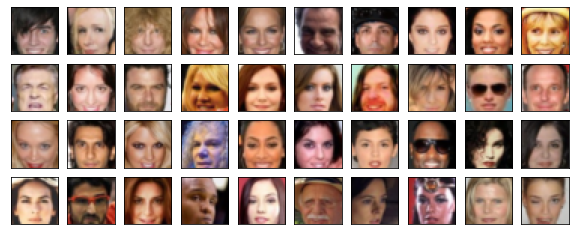

In [11]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    #print(npimg)
    #plt.imshow(npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

#get a batch of training images
data_iter = iter(celeba_train_loader)
images,nolabel=data_iter.next()
#ploting the images that we are taking
fig=plt.figure(figsize=(10,4))
#always should be even numbers
psize=40
for var in np.arange(psize):
    ax = fig.add_subplot(4,int(psize/4),var+1,xticks=[], yticks=[])
    imshow(images[var])

In [13]:
img = images[0]
feature_range=(-1, 1)
min, max = feature_range
scaled_img = img*(max-min) + min

In [14]:
# check scaled range
# should be close to -1 to 1
#img = images[0]
#scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9294)
Max:  tensor(0.7725)


## Defining the model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
def conv(input_c,output,kernel_size,stride = 2,padding  = 1, batch_norm = True):
    layers =[]
    con = nn.Conv2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(con)

    if batch_norm:
        layers.append(nn.BatchNorm2d(output))

    return nn.Sequential(*layers)

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False) #16
        self.layer_2 = conv(conv_dim,conv_dim*2,4) #8
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4) #4
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        # complete init function


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.layer_1(x))
        x = F.leaky_relu(self.layer_2(x))
        x = F.leaky_relu(self.layer_3(x))
        x = x.view(-1,self.conv_dim*4*4*4)
        x = self.fc(x)
        return x

# used to check if model will be trained on gpu
tests.test_discriminator(Discriminator)

Tests Passed


In [17]:
def deconv(input_c,output,kernel_size,stride = 2, padding =1, batch_norm = True):
    layers = []
    decon = nn.ConvTranspose2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(decon)

    if batch_norm:
        layers.append(nn.BatchNorm2d(output))
    return nn.Sequential(*layers)

class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size,conv_dim*8*2*2)
        self.layer_1 = deconv(conv_dim*8,conv_dim*4,4)
        self.layer_2 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_3 = deconv(conv_dim*2,conv_dim,4)
        self.layer_4 = deconv(conv_dim,3,4,batch_norm = False)
        # complete init function

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1,self.conv_dim*8,2,2) #(batch_size,depth,width,height)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = torch.tanh(self.layer_4(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


In [18]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    if hasattr(m,'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):

        m.weight.data.normal_(0.0,0.02)

        if hasattr(m,'bias') and m.bias is not None:
            m.bias.data.zero_()


In [19]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)

    return D, G

In [20]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (layer_1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding

In [21]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [22]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion =  nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [23]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr = .0002, betas = [0.5,0.999])
g_optimizer = optim.Adam(G.parameters(),lr = .0002, betas = [0.5,0.999])

In [26]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=5
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            #real_images = scale(real_images)
            feature_range=(-1, 1)
            min, max = feature_range
            real_images = real_images*(max-min) + min
            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            d_out_real = D(real_images)
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            d_loss = real_loss(d_out_real) + fake_loss(D(G(z)))
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            G.train()
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            g_loss = real_loss(D(G(z)))
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

In [27]:
# set number of epochs
n_epochs = 1 # 25, 50, 75, 100, 200, 500 -> No of epochs changed in higher GPU machine


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/    1] | d_loss: 0.0799 | g_loss: 4.0087
Epoch [    1/    1] | d_loss: 0.5995 | g_loss: 4.0236
Epoch [    1/    1] | d_loss: 0.6684 | g_loss: 2.6250
Epoch [    1/    1] | d_loss: 0.6461 | g_loss: 2.1877
Epoch [    1/    1] | d_loss: 0.9747 | g_loss: 4.7195


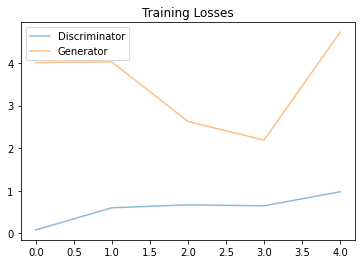

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [29]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255/2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [30]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

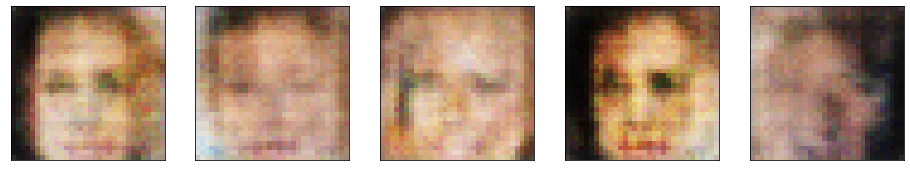

In [31]:
_ = view_samples(-1, samples)